In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score

In [69]:
# read in the data
data = pd.read_csv('train.csv')
data.head()

,teaching,teaching.1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,0.0,teacher are punctual but they should also give...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,Good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,Excellent lectures are delivered by teachers a...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,Good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,teachers give us all the information required ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
# Getting the row and columns size
data.shape

(370, 12)

In [118]:
# Creating a duplicate of the data to avoid issh in the future.
df = data.copy()
df = df.loc[:, ['teaching', 'teaching.1']].rename(columns={'teaching':'Sentiment', 'teaching.1':'SentimentText'})

In [120]:
# Changing the -1 to 0 coz multiclass sentiment is not what we need 

sentiment = []
for senti in df['Sentiment']:
    if senti == -1:
        sentiment.append(0)
    elif senti == 0:
        sentiment.append(0)
    else:
        sentiment.append(1)
df['sentiment'] = sentiment
df.sentiment.head()

0    0
1    1
2    1
3    1
4    1
Name: sentiment, dtype: int64

In [74]:
# This process can introduce bias to the model it is not advisable
# it is used to balance the target like negative 0 should be equal or close to equal in length 

from sklearn.utils import resample
df_majority = df[df.sentiment == 1]
df_minority = df[df.sentiment == 0]

df_minority_upsampled = resample(df_minority,
                                replace=True,
                                n_samples=260,
                                random_state=42)
df = pd.concat([df_majority, df_minority_upsampled])
df.sentiment.value_counts()

1    266
0    260
Name: sentiment, dtype: int64

**MODEL**

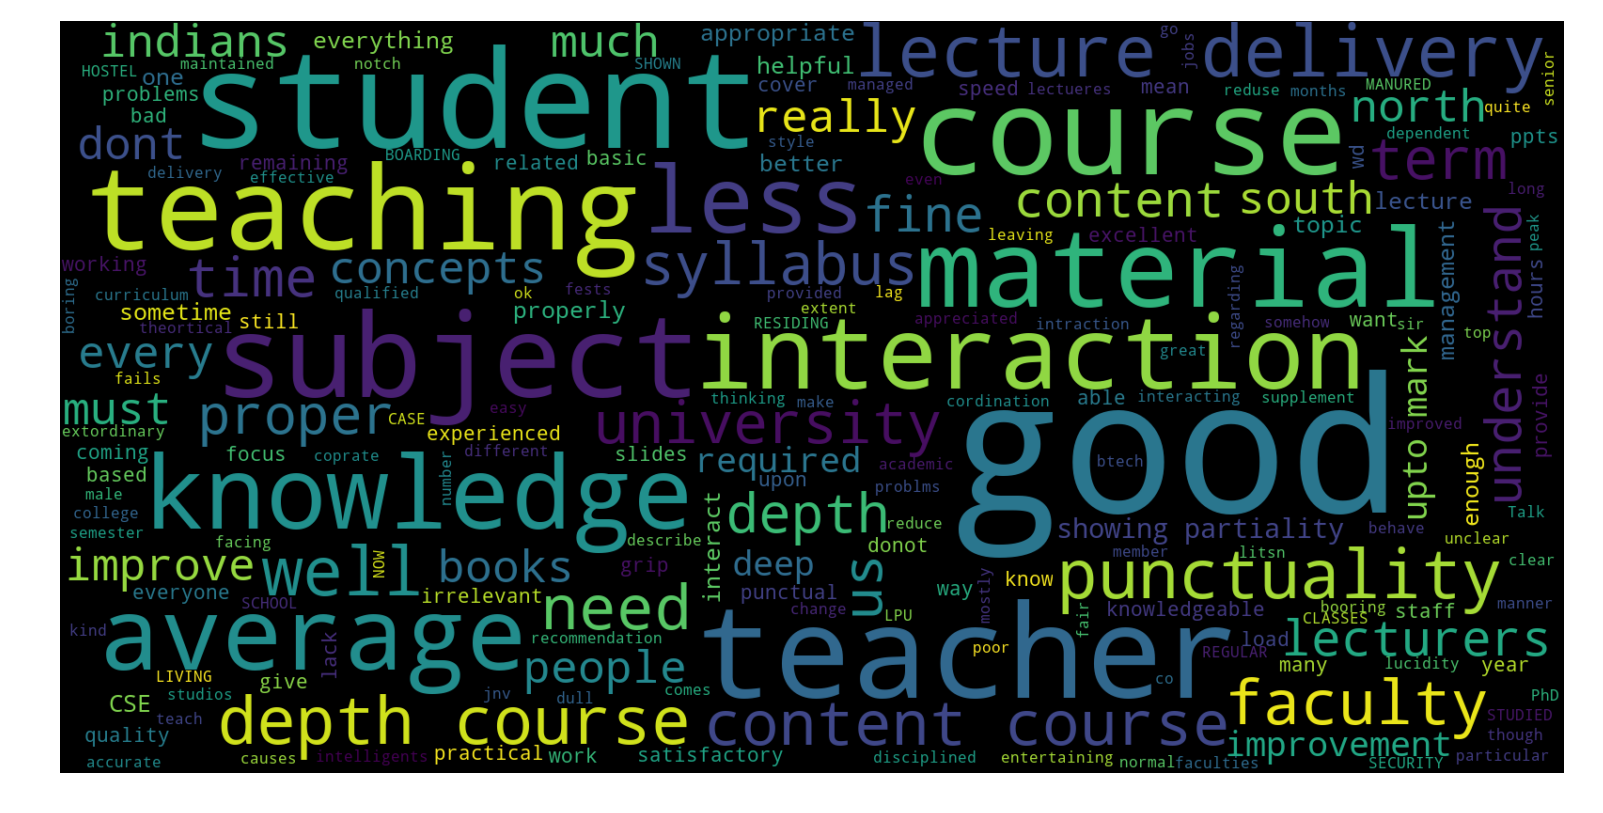

In [122]:
# Data Visualization

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from wordcloud import WordCloud, STOPWORDS


neg_comments = df[df.sentiment == 0]
neg_string = []
for t in neg_comments.SentimentText:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

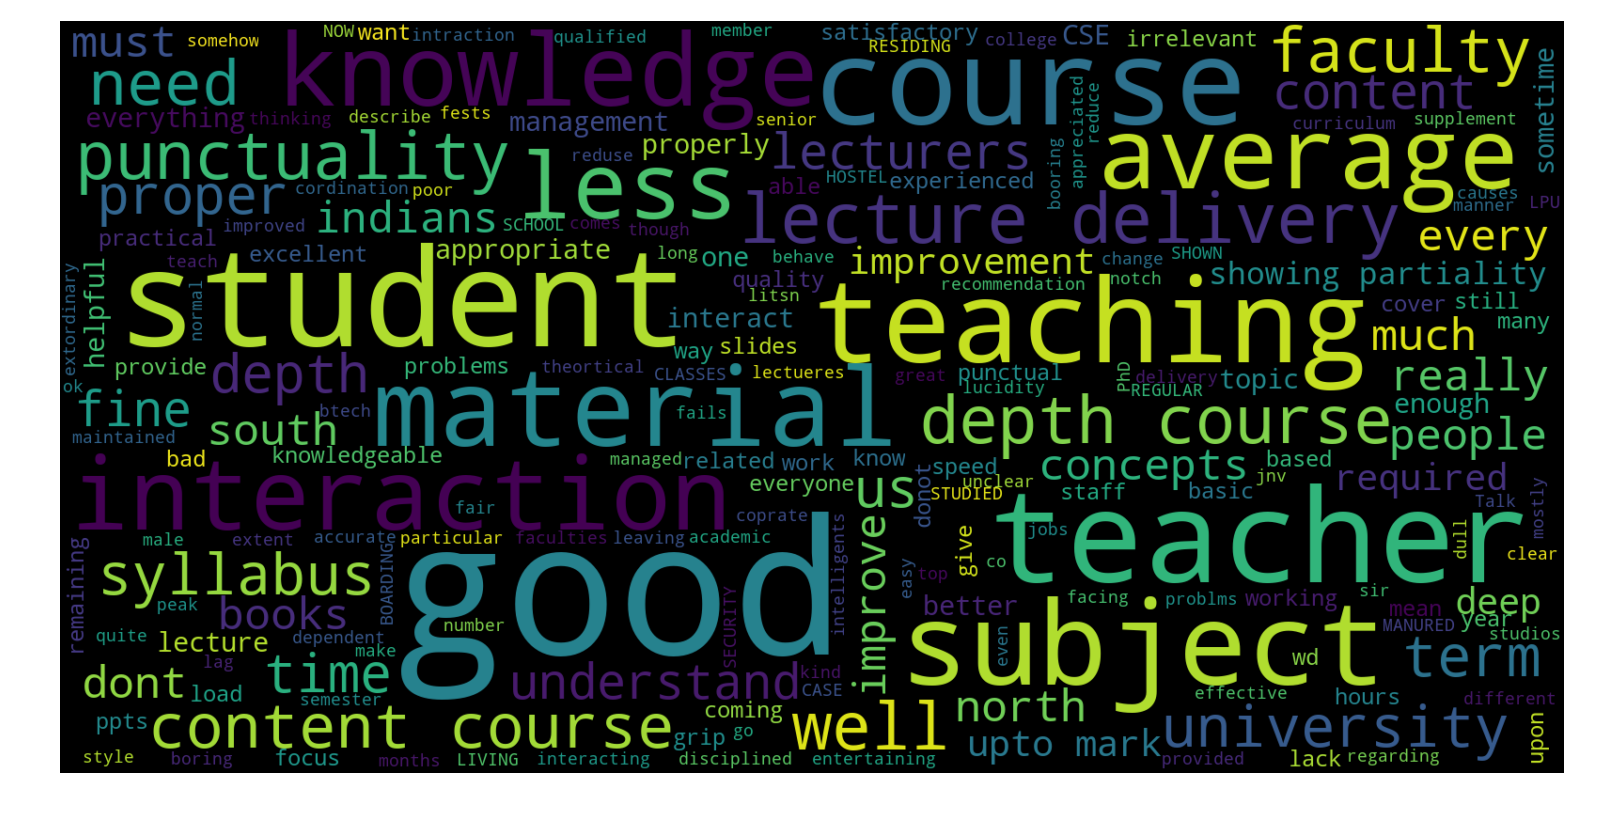

In [123]:
# Data Visualization

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from wordcloud import WordCloud, STOPWORDS


pos_comments = df[df.sentiment == 1]
pos_string = []
for t in pos_comments.SentimentText:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(pos_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [124]:
# import nltk
# nltk.download('punkt')
# nltk.download('stopwords')

# This is the cleaning process to deal with text data, it has to be cleaned with some important process
# i created 2 functions one is to tokenize means separate each sentence into words
# stem is used to get each word and remove either prefix, suffix and or 
# Then i remove stopwords like 'not', 'a', 'the' etc
# i called a CountVectorizer class and i implement all the cleaning process into it in just a single line AWESOME
def tokenize(text):
    tokenzr = word_tokenize(text)
    return tokenzr

def stem(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

en_stopwords = set(stopwords.words("english"))
stop_words_list = ("'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would')
en_stopwords = en_stopwords.add(stop_words_list)

vectorizer = CountVectorizer(analyzer='word', tokenizer=tokenize, lowercase=True, ngram_range=(1,2), stop_words=en_stopwords)

In [125]:
# this is used to train the model n_splits times and shuffle the samples everytime
kfolds = StratifiedKFold(n_splits=4, shuffle=True, random_state=41)

In [126]:
X = df['SentimentText'] # i only used the teaching.1 column as that is more of the teachers aspect since that what we are dealing with 
y = df['sentiment'] # this is the dependent variable otherwise the target variable

# Split to train and test set with the train_test_split function
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=123)

In [127]:
# making a pipeline to train the model
pipeline_svm = make_pipeline(vectorizer, SVC(probability=True, kernel='linear', class_weight='balanced'))

# the grid search that is used to train the model
svm_model = GridSearchCV(pipeline_svm, 
                        param_grid={'svc__C': [0.001, 0.01, 0.05, 1]}, 
                        cv=kfolds, 
                        scoring='accuracy', 
                        n_jobs=1)

# Actual training
svm_model.fit(X_train, y_train)

# evaluating based on score
svm_model.score(X_test, y_test)

0.8828828828828829

In [128]:
# Best performing score after Grid Search
svm_model.best_score_, svm_model.best_estimator_

(0.888030888030888, Pipeline(memory=None,
          steps=[('countvectorizer',
                  CountVectorizer(analyzer='word', binary=False,
                                  decode_error='strict',
                                  dtype=<class 'numpy.int64'>, encoding='utf-8',
                                  input='content', lowercase=True, max_df=1.0,
                                  max_features=None, min_df=1,
                                  ngram_range=(1, 2), preprocessor=None,
                                  stop_words=None, strip_accents=None,
                                  token_pattern='(?u)\\b\\w\\w+\\b',
                                  tokenizer=<function tokenize at 0x0929A7C8>,
                                  vocabulary=None)),
                 ('svc',
                  SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
                      decision_function_shape='ovr', degree=3,
                      gamma='auto_deprecated', kernel='linear', 

In [129]:
# A function to evaluate the model
def report_results(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1] # a probability score (how sure the model is)
    pred = model.predict(X)        # prediction which can be 1 positive or 0 negative

    auc = roc_auc_score(y, pred_proba) # AUC - Area Under Curve means how high or close the model is to 1 the higher the beta
    acc = accuracy_score(y, pred)   # Accuaracy high accuracy is prefered atleast more than 70%
    f1 = f1_score(y, pred)
    prec = precision_score(y, pred) # more like accurate
    rec = recall_score(y, pred)
    result = {'auc': auc, 'f1': f1, 'acc': acc, 'precision': prec, 'recall': rec}
    return result

In [130]:
report_results(svm_model.best_estimator_, X_test, y_test)

{'auc': 0.8997668997668998,
 'f1': 0.9182389937106918,
 'acc': 0.8828828828828829,
 'precision': 0.9012345679012346,
 'recall': 0.9358974358974359}

In [131]:
# A function to Calcualte the ROC plot
def get_roc_curve(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, pred_proba)
    return fpr, tpr

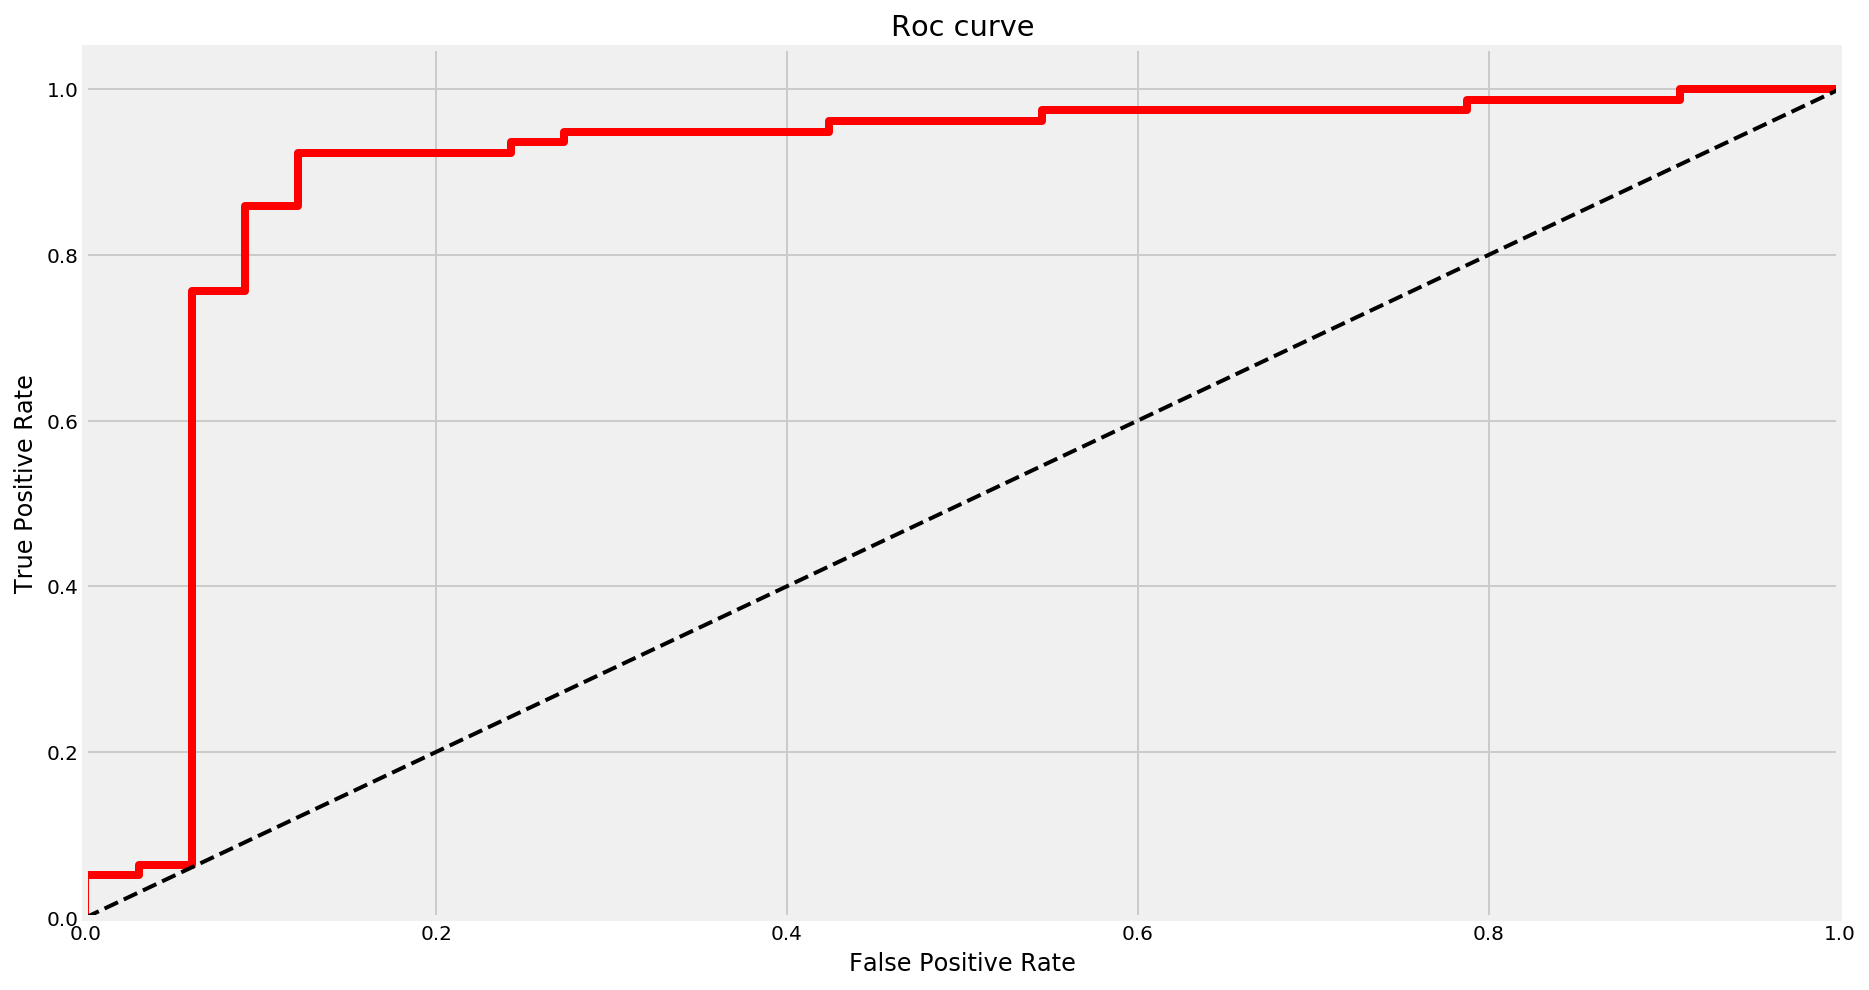

In [132]:
# Receiver Operating Characteristics Curve to show how good the model is
roc_svm = get_roc_curve(svm_model.best_estimator_, X_test, y_test)

fpr, tpr = roc_svm
plt.figure(figsize=(14,8))
plt.plot(fpr, tpr, color="red")
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc curve')
plt.show()

In [133]:
# Testing the Model
svm_model.predict(["The Teacher tried but he was too fast with his dictation"])

array([1], dtype=int64)

In [111]:
# Testing the Model
svm_model.predict(['He is very smart and challenging lecturer. Good behaviour towards teaching and learning'])

array([1], dtype=int64)

In [112]:
# Testing the Model

svm_model.predict(['He expects students to have an acceptable level of the basics themselves, hence, hes clear to students who have an idea of the subject beforehand; the rest find him a bit '])

array([0], dtype=int64)

In [134]:
# Function To Predict Sentiment
def predict_sentiment(word):
    response = [word]
    prediction = svm_model.predict(response)
    predict_proba = grid_svm.predict_proba(response)[:,1]
    if prediction == 1:
        print("The Sentiment is Positive (+) with an Accuracy of ", predict_proba)
    else:
        predict_proba = grid_svm.predict_proba(response)[:,0]
        print("The Sentiment is Negative (-) with an Accuracy of ", predict_proba)
  #return prediction, predict_proba


In [135]:
predict_sentiment('He is very smart and challenging lecturer. Good behaviour towards teaching and learning')

The Sentiment is Positive (+) with an Accuracy of  [0.96780795]


A New Model

In [136]:
predict_sentiment('The Lecturer was so boring, i did not understand anything from the lecture')

The Sentiment is Negative (-) with an Accuracy of  [0.80878028]


In [91]:
test = pd.read_csv('test.csv')
test.head()

,ID,Start time,Completion time,Email,Name,What is your matric no?,Select your departmental course,What are your view of the lecturer regarding his/her relationship with students?,What is your perception about the lecturer's clarity of explanation?,What opinion do you have regarding the lecturer's coverage of course content?,What is your opinion about the lecturer's mode of teaching?,What are your perceptions about the lecturer with respect to tests and assessment evaluation?,Comment
0,1,5/8/2019 12:36,5/8/2019 12:42,anonymous,NaN,15/52ha032,CSC311 (Automata Theory and Formal Language),The lecturer relates with student in a good ma...,His clarity of explanation is good,"By percentage, 76%",Excellent,He rarely gives assignment but his test is ver...,He is very smart and challenging lecturer. Goo...
1,2,5/8/2019 13:44,5/8/2019 13:46,anonymous,NaN,15/52ha047,CSC311 (Automata Theory and Formal Language),His relationship is good,Poor,He should be brief and stop talking about irre...,I don't know what to say on this,Good,Not really good
2,3,5/8/2019 13:48,5/8/2019 13:53,anonymous,NaN,15/52HA076,CSC311 (Automata Theory and Formal Language),His relationship with students is quite ok,Not really clear,He should take his time.. Slow and steady doe...,Too high.. Only the scholar end up understanding,I don't know about this,Not too bad but they should come down to stude...
3,4,5/8/2019 13:52,5/8/2019 13:54,anonymous,NaN,16/52hp101,TCS325 (Broadband Wireless Network I),Normal,Good,It is okay,Normal,Normal,Good
4,5,5/8/2019 13:46,5/8/2019 13:54,anonymous,NaN,15/52HA014,CSC311 (Automata Theory and Formal Language),He is friendly and free with students,He emphasize alot on main points,Good,Excellent,Not bad,A weldone job


#### The Test Data Can be used to experiment and improve the model Thank You